## Extras - 2nd edition

In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
import powerlaw
from scipy.stats import poisson
from scipy.optimize import fsolve
import random
datadir='../Datasets/'


## Question 2.9

For any $\bar{d} \in \{1, 2, \ldots, 15\}$, generate $\mathcal{G}(n,p)$ and $\mathcal{RGG}(n,r)$ of comparable average degree; that is, $p$ and $r$ are such that 
$(n-1)p = (n-1) \pi r^2 = \bar{d}.$

(q) Specify $n$?

* (a) Compare (global) clustering coefficients of the corresponding models. Which model produces larger ones? Any intuition why?

For $\bar{d} = 10$, do the following additional experiments.
* (b) Compare diameters of the corresponding models. Which model produces larger ones? Any intuition why?
* (c) Compare the degree distribution of the corresponding models. Any visible difference?
* (d) Consider the giant components, if any of the two graphs are disconnected. Sample \pc{how many?} pairs of nodes. For each pair, plot $(x,y)$ where $x$ is the Euclidean distance between the two nodes and $y$ is the corresponding graph distance. Any visible correlation? Any intuition why?


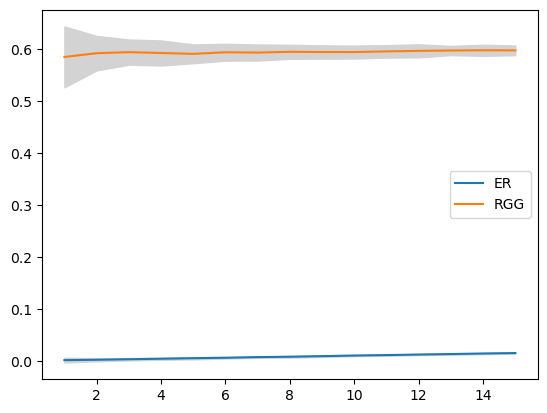

In [2]:
## (a) clustering coefficient
avg_deg = np.arange(1,16,1)
n = 1000
torus = False
repeats = 100

## generate random graphs 
er_cc = []
rgg_cc = []
er_std = []
rgg_std = []

for deg in avg_deg:
    # G(n,p)
    p = deg/(n-1) ## for ER
    x = []
    for i in range(repeats):
        g_er = ig.Graph.Erdos_Renyi(n=n, p=p)
        x.append(g_er.transitivity_undirected())
    er_cc.append(np.mean(x))
    er_std.append(np.std(x))
    # RGG()
    radius = np.sqrt(deg/(np.pi*(n-1)))
    x = []
    for i in range(repeats):
        g_rgg = ig.Graph.GRG(n=n, radius=radius, torus=torus)
        x.append(g_rgg.transitivity_undirected())
    rgg_cc.append(np.mean(x))
    rgg_std.append(np.std(x))
    
plt.plot(avg_deg, er_cc, label='ER')
plt.fill_between(avg_deg,[x[0]+1.654*x[1] for x in zip(er_cc,er_std)],
                 [x[0]-1.645*x[1] for x in zip(er_cc,er_std)],color='lightgray')

plt.plot(avg_deg, rgg_cc, label='RGG')
plt.fill_between(avg_deg,[x[0]+1.654*x[1] for x in zip(rgg_cc,rgg_std)],
                 [x[0]-1.645*x[1] for x in zip(rgg_cc,rgg_std)],color='lightgray')

plt.legend();

7 106


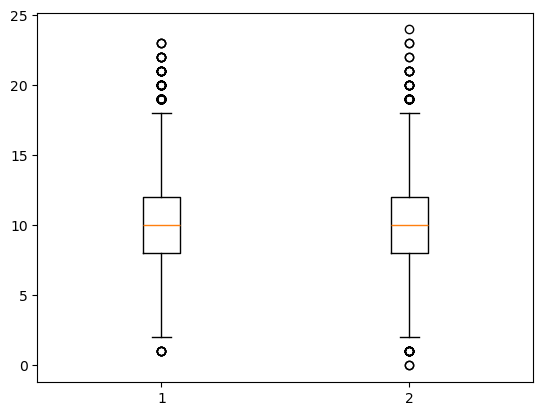

In [3]:
## (b) diameter and (c) degree distribution
deg = 10
n = 10000
p = deg/(n-1) ## for ER
radius = np.sqrt(deg/(np.pi*(n-1)))
g_er = ig.Graph.Erdos_Renyi(n=n, p=p)
g_rgg = ig.Graph.GRG(n=n, radius=radius, torus=torus)
print(g_er.diameter(), g_rgg.diameter())
plt.boxplot([g_er.degree(), g_rgg.degree()]);



In [4]:
def L2(X,Y):
    return np.sqrt((Y[0]-X[0])**2 + (Y[1]-X[1])**2)

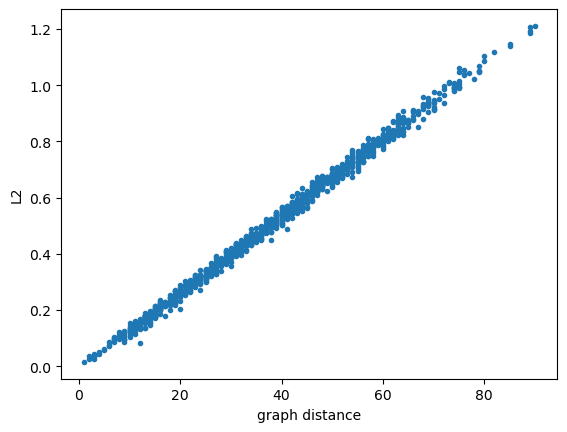

In [5]:
## (d) RGG - distance vs euclidean distance

deg = 10
n = 10000
radius = np.sqrt(deg/(np.pi*(n-1)))
g_rgg = ig.Graph.GRG(n=n, radius=radius, torus=torus)

d_l2 = []
d_g = []

for i in range(1000):
    pair = np.random.choice(n, 2, replace=False)
    a = pair[0]
    b = pair[1]
    d_g.append(g_rgg.distances(a,b)[0][0])
    d_l2.append(L2([g_rgg.vs[a]['x'],g_rgg.vs[a]['y']], [g_rgg.vs[b]['x'],g_rgg.vs[b]['y']]))

plt.plot(d_g, d_l2, '.')
plt.xlabel('graph distance')
plt.ylabel('L2');


# Question 3.5

In [46]:
## define colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()

## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
df = A.head()
print(g.vcount(),'nodes and',g.ecount(),'directed edges')


464 nodes and 12000 directed edges


In [52]:
g.es[0]

igraph.Edge(<igraph.Graph object at 0x28397c850>, 0, {'weight': 1442105, 'color': 'gainsboro', 'arrow_size': 0.33})

In [47]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(G.strength(mode='in',weights=weights),\
              G.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in G.strength(weights=weights)]
    return dc

In [63]:
## extra - state graph (Chapter 3)
## Given g -- airport graph
state_map = {v:k for k,v in enumerate(set(g.vs['state']))}
vertex_map = [state_map[i] for i in g.vs['state']]
G = g.copy()
G.contract_vertices(vertex_map, combine_attrs={'state':'first'})
G.vs[0]

igraph.Vertex(<igraph.Graph object at 0x2843e6050>, 0, {'state': 'LA'})

In [64]:
G = G.simplify(multiple=True,loops=True,combine_edges={'weight':'sum','color':'first','arrow_size':'first'})
G.es[0]

igraph.Edge(<igraph.Graph object at 0x2843e6050>, 0, {'weight': 804643.0, 'color': 'gainsboro', 'arrow_size': 0.33})

In [49]:

#G.vs['name'] = list(state_map.keys())


igraph.Vertex(<igraph.Graph object at 0x28397cd50>, 0, {'name': 'LA'})

In [66]:
G.vs['name'] = G.vs['state']

In [71]:
G.vs['in'] = [G.strength(i,'in',weights='weight') for i in range(G.vcount())]
G.vs['out'] = [G.strength(i,'out',weights='weight') for i in range(G.vcount())]

In [78]:
## compute normalized weights 
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]
## compute several centrality measures
C = pd.DataFrame({'state':G.vs()['name'],\
                  'degree':degree_centrality(G,weights='normalized_weight'),\
                  'pagerank':G.pagerank(weights='weight'),'authority':G.authority_score(weights='weight'),\
                  'hub':G.hub_score(weights='weight'),'between':G.betweenness(),\
                  'closeness':G.closeness()})
## normalize betweenness
n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality, look at top airports
Cs = C.sort_values(by='degree', ascending=False)
print(Cs.head(),'\n')
print(Cs.tail(),'\n')
## edge with highest weight
e = np.argmax(G.es['weight'])
print('top edge:',G.vs[G.es[e].tuple[0]]['name'],G.vs[G.es[e].tuple[1]]['name'],G.es[e]['weight'])
## nodes with highest in/out weights
G.vs['in'] = G.strength(mode='IN',weights='weight')
G.vs['out'] = G.strength(mode='OUT',weights='weight')
print('top in/out nodes:',G.vs[np.argmax(G.vs['in'])]['name'],G.vs[np.argmax(G.vs['out'])]['name'])


   state    degree  pagerank  authority       hub   between  closeness
16    CA  0.135169  0.075945   0.969771  0.971337  0.021798   0.943396
26    FL  0.131269  0.073844   1.000000  1.000000  0.025327   0.943396
4     TX  0.130073  0.077688   0.925013  0.925349  0.028044   0.980392
1     GA  0.107684  0.064350   0.829178  0.827263  0.024180   0.961538
17    IL  0.104197  0.063423   0.743696  0.742924  0.037366   1.000000 

   state    degree  pagerank  authority       hub   between  closeness
48    SD  0.001468  0.003813   0.008584  0.008501  0.005518   0.781250
31    WV  0.000819  0.003366   0.006263  0.006313  0.000951   0.666667
15    WY  0.000741  0.003410   0.004858  0.004661  0.002636   0.735294
49    ID  0.000652  0.003370   0.002167  0.002198  0.001177   0.617284
35    DE  0.000004  0.002943   0.000022  0.000025  0.000229   0.581395 

top edge: FL GA 6584065.0
top in/out nodes: CA CA


In [79]:
G.is_connected(mode='STRONG')

True

# Question 4.6

In [80]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples


In [81]:
## power law graph
gamma = 2.1
n = 10000
delta = 1
Delta = 5*np.sqrt(n)
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

deg = [int(np.round(w)) for w in W]
## even degree sum
if sum(deg)%2 == 1:
    deg[0]-=1


In [82]:
# undirected
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        # w = [deg[i] for i in list(set(G.neighbors(v)))] 
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

## degree correlation for neutral graphs: <k^2>/<k>
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)    



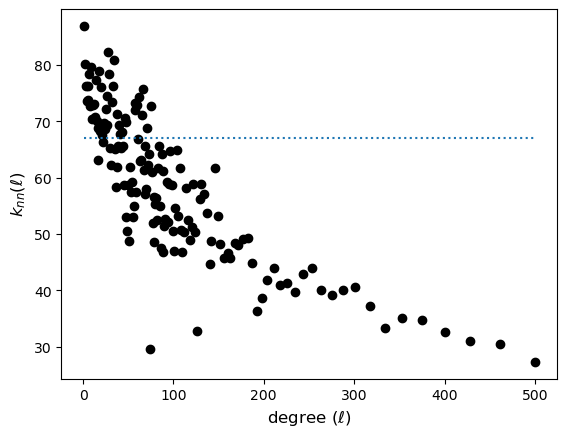

In [83]:
cm = ig.Graph.Degree_Sequence(deg,method="vl")
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);

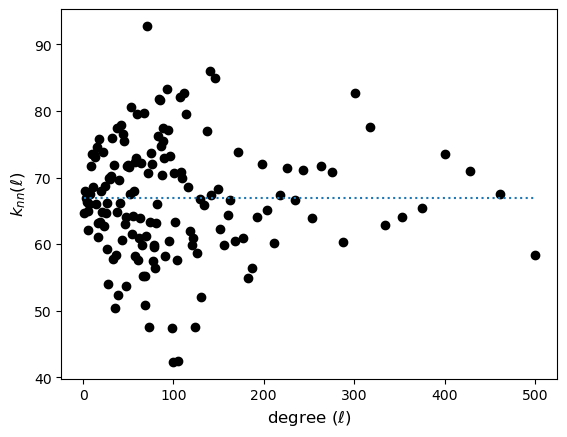

In [84]:
cm = ig.Graph.Degree_Sequence(deg,method="simple")
knn = deg_corr(cm)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_neutral(cm)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);

# Chap 4 questions SPA


In [31]:
## unit square torus distance
def torusDist(U,V):
    dx = np.abs(V[0]-U[0])
    dy = np.abs(V[1]-U[1])
    if dx > 0.5:
        dx = 1 - dx
    if dy > 0.5:
        dy = 1 - dy
    return np.sqrt(dx*dx+dy*dy)

# unit square (non-torus) distance
def squareDist(U,V):
    dx = np.abs(V[0]-U[0])
    dy = np.abs(V[1]-U[1])    
    return np.sqrt(dx*dx+dy*dy)

# build a SPA graph given the parameters described above
def buildSPA(n, p, A1, A2, seed=12345):
    ## random points 
    rng = np.random.default_rng(seed=seed)
    X = rng.random(n)
    Y = rng.random(n)
    pts = [(X[i],Y[i]) for i in range(n)]

    ## initialize new graph
    t = 0
    G = ig.Graph(directed=True)

    ## add vertices
    for v in range(n):
        G.add_vertex(str(v))
        G.vs[v]['loc'] = pts[v]
        for i in range(v):
            if torusDist(G.vs[v]['loc'],G.vs[i]['loc']) < G.vs[i]['r']: 
                if rng.random() < p:
                    G.add_edge(v,i)   
        t += 1
        G.vs['r'] = [np.sqrt(min(1,(A1*d+A2)/t)/np.pi) for d in G.degree(mode='in')]
    return G

In [40]:
## parameters
n = 500 ## we use small n so we can quickly do multiple runs
p = .5
A2 = 3

A = np.arange(0.1,3.1,.1)

empirical = []
theory = []

for A1 in A:
    G = buildSPA(n, p, A1, A2, seed=123)
    deg_in = G.degree(mode='in')
    X = powerlaw.Fit(deg_in, verbose=False)
    empirical.append(X.power_law.alpha)
    theory.append(1+1/(p*A1))


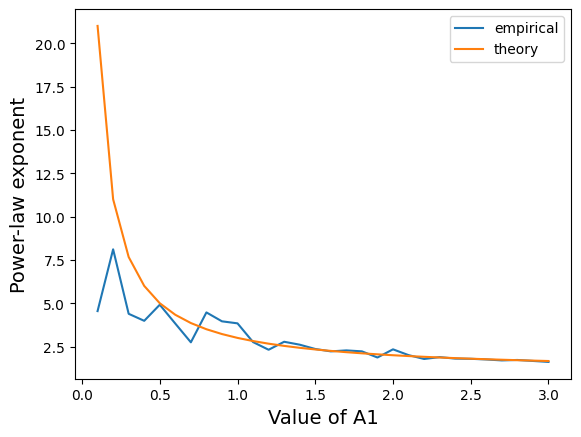

In [41]:
plt.plot(A, empirical,label='empirical')
plt.plot(A, theory, label='theory')
plt.xlabel('Value of A1', fontsize=14)
plt.ylabel('Power-law exponent', fontsize=14)
plt.legend();


In [33]:
## parameters
n = 1000
p = 0.667
A1 = 1
A2 = 3
seed = 1234

G_spa = buildSPA(n, p, A1, A2, seed=seed)
print("number of edges:", G_spa.ecount())

number of edges: 5063


[[1.         0.90599477]
 [0.90599477 1.        ]]


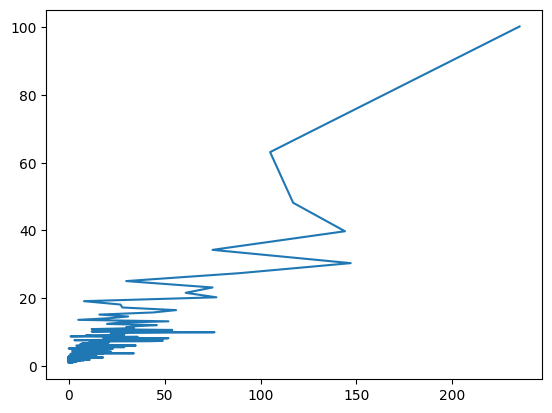

In [34]:
deg_in = G_spa.degree(mode='in')
y = [(n/(t+1))**(p*A1) for t in range(G_spa.vcount())]
print(np.corrcoef(deg_in,y))
plt.plot(deg_in,y);

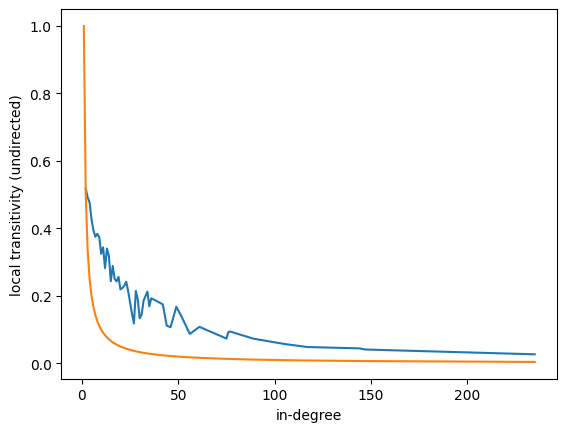

In [35]:
cc = G_spa.transitivity_local_undirected()
dct = {x:[] for x in set(deg_in)}
for i in range(G_spa.vcount()):
    dct[deg_in[i]].append(cc[i])
x = np.sort(list(set(deg_in)))[1:]
y = [np.mean(dct[i]) for i in x]
plt.plot(x,y)
plt.plot(x,1/x)
plt.xlabel('in-degree')
plt.ylabel('local transitivity (undirected)');


# Testing 'fastnode2vec' package

Note: using a single worer and seed fpr reproducibility

In [2]:
from fastnode2vec import Graph, Node2Vec
states = ['CA','PA','HI']
cls = ['blue','red','orange']
cls_dict = {i:j for i,j in zip(states,cls)}


In [3]:
## load the airport dataset

## read edges and build weighted directed graph
df = pd.read_csv(datadir+'Airports/connections.csv')
g_airport = ig.Graph.TupleList([tuple(x) for x in df.values], directed=True, edge_attrs=['weight'])

## read vertex attributes and add to graph
Attr = pd.read_csv(datadir+'Airports/airports_loc.csv')

## map airports in Attr to the node order in graph g
lookup = {k:v for v,k in enumerate(Attr['airport'])}
l = [lookup[x] for x in g_airport.vs()['name']]

## save lat/lon as tuples for each node:
g_airport.vs()['layout'] = [(Attr['lon'][i],Attr['lat'][i]) for i in l]
g_airport.vs()['state'] = [Attr['state'][i] for i in l]
g_airport.vs()['city'] = [Attr['city'][i] for i in l]
Attr.head() ## first few rows in Attr

## add a few more attributes for visualization
g_airport.vs()['size'] = 8
g_airport.es()['arrow_size'] = 0.33
print('Airport graph:',g_airport.vcount(), 'nodes and', g_airport.ecount(), 'directed edges')


Airport graph: 464 nodes and 12000 directed edges


In [4]:
## subgraph, pick a few states
V = [v for v in g_airport.vs if v['state'] in states]
sg = g_airport.subgraph(V)
sg = sg.connected_components(mode='weak').giant()
sg = sg.simplify()
sg = sg.as_undirected()

Reading graph:   0%|                                                                                          …

Epochs:   0%|                                                                                                 …

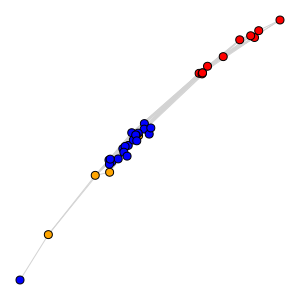

In [6]:
## n2v in 2-dim
graph = Graph(sg.to_tuple_list(), directed=False, weighted=False)
n2v = Node2Vec(graph, dim=2, walk_length=100, window=5, workers=1, seed=123)
n2v.train(epochs=100)
for v in sg.vs:
    v['color'] = cls_dict[v['state']]
ly = [n2v.wv[i] for i in range(len(n2v.wv))]
ig.plot(sg, layout=ly, bbox=(300,300), edge_color='lightgrey')


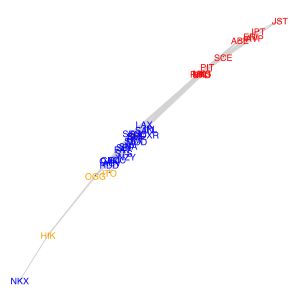

In [7]:
for v in sg.vs:
    v['label_color'] = v['color']
    v['label'] = v['name']
ig.plot(sg, layout=ly, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, vertex_label_size=9)

In [8]:
## n2v with dim=8, then viz in 2d with umap
n2v = Node2Vec(graph, dim=8, walk_length=100, window=5, workers=1, seed=123)
n2v.train(epochs=100)


Epochs:   0%|                                                                                                 …

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


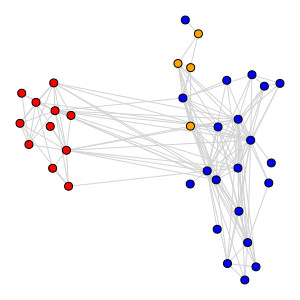

In [9]:
import umap
Y = np.array([n2v.wv[i] for i in range(len(n2v.wv))])
ly = umap.UMAP(random_state=42, n_jobs=1).fit_transform(Y)
ig.plot(sg, bbox=(300,300), layout=ly, edge_color='lightgrey', vertex_label_size=0)

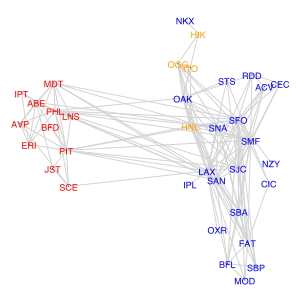

In [10]:
ig.plot(sg, layout=ly, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, vertex_label_size=9)

# Testing scikit-network package


In [11]:
import sknetwork as skn
from sklearn.metrics import adjusted_mutual_info_score as AMI

In [12]:
A = sg.get_adjacency_sparse()

In [25]:
# Training set
dct = {j:i for i,j in enumerate(states)} ## use integers for the class labels
labels = np.array([dct[i] for i in sg.vs['state']])
np.random.seed(42)
train_mask = np.random.random(size=len(labels)) < 0.3
labels[train_mask] = -1 ## negative labels are ignored
sg.vs['class'] = labels

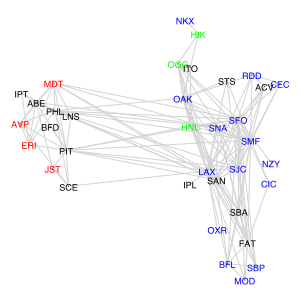

In [26]:
cls_plus = ['black']+cls ## use black for test points
for v in sg.vs:
    v['label_color'] = cls_plus[v['class']+1]

## previous layout from node2vec
ig.plot(sg, bbox=(300,300), layout=ly, edge_color='lightgrey', vertex_size=.1, vertex_label_size=9)


In [27]:
# GNN classifier with a single hidden layer
hidden_dim = 5
n_labels = len(states)

gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, n_labels],
                    layer_types='Conv',
                    #layer_types='Sage',
                    activations='ReLu',
                    verbose=True)

## for features, simply use shortest path len to all nodes, or just the adjacency matrix
features = np.array(sg.distances(mode='all'))
#features = A.copy()
Pred = gnn.fit_predict(A, features, labels=labels, n_epochs=200, random_state=42, history=True)


In epoch   0, loss: 0.850, train accuracy: 0.682
In epoch  20, loss: 0.824, train accuracy: 0.636
In epoch  40, loss: 0.800, train accuracy: 0.682
In epoch  60, loss: 0.736, train accuracy: 0.909
In epoch  80, loss: 0.660, train accuracy: 0.909
In epoch 100, loss: 0.604, train accuracy: 0.955
In epoch 120, loss: 0.596, train accuracy: 0.955
In epoch 140, loss: 0.591, train accuracy: 0.955
In epoch 160, loss: 0.589, train accuracy: 0.955
In epoch 180, loss: 0.589, train accuracy: 0.955


In [28]:
from sknetwork.classification import get_accuracy_score
#test_mask = ~train_mask
labels = np.array([dct[i] for i in sg.vs['state']])
#get_accuracy_score(np.array(sg.vs['class'])[train_mask], np.array(sg.vs['pred'])[train_mask])
get_accuracy_score(labels[train_mask], Pred[train_mask])


1.0

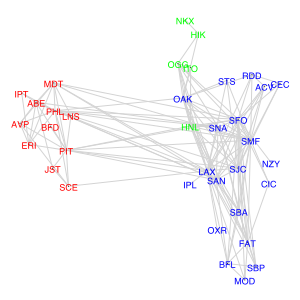

In [29]:
sg.vs['pred'] = Pred
cls = ['blue','red','green']
for v in sg.vs:
    v['label_color'] = cls[v['pred']]
ig.plot(sg, layout=ly, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, vertex_label_size=9)

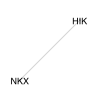

In [21]:
# NKX and HIK are air force bases
# NKX egonet in this subgraph
v = sg.neighborhood(sg.vs.find('NKX'))
sg_sfo = sg.subgraph(v)
ig.plot(sg_sfo, bbox=(100,100), edge_color='lightgrey', vertex_size=.1, vertex_label_size=9, 
        vertex_label_color='black')

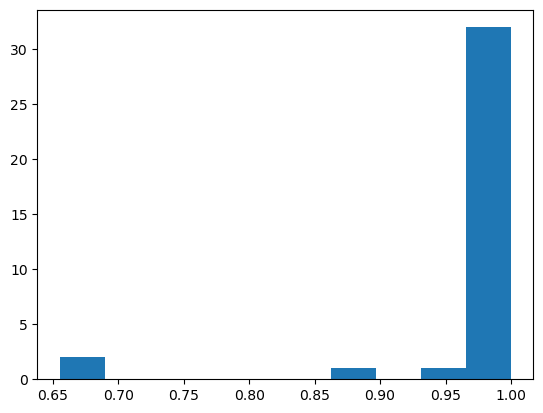

In [22]:
## probabilities - we show the max value for each data point
import seaborn as sns
plt.hist([np.max(p) for p in gnn.predict_proba()], bins=10);

In [23]:
print(gnn)

GNNClassifier(
    Convolution(layer_type: conv, out_channels: 5, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 3, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)


In [24]:
emb = gnn.fit_transform(A, features, labels=labels, n_epochs=200, random_state=42, history=True)
ly = umap.UMAP(random_state=42, n_jobs=1).fit_transform(emb)

In epoch   0, loss: 0.581, train accuracy: 0.972
In epoch  20, loss: 0.570, train accuracy: 0.972
In epoch  40, loss: 0.568, train accuracy: 0.972
In epoch  60, loss: 0.573, train accuracy: 0.972
In epoch  80, loss: 0.568, train accuracy: 0.972
In epoch 100, loss: 0.566, train accuracy: 1.000
In epoch 120, loss: 0.565, train accuracy: 1.000
In epoch 140, loss: 0.568, train accuracy: 0.972
In epoch 160, loss: 0.564, train accuracy: 1.000
In epoch 180, loss: 0.566, train accuracy: 0.972


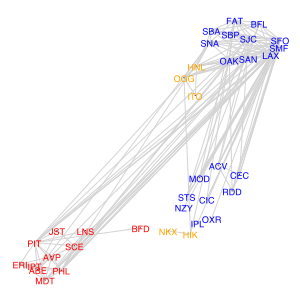

In [25]:
ig.plot(sg, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, vertex_label_size=9, layout=ly)

In [26]:
graph = skn.data.karate_club(metadata=True)
A = graph.adjacency
g = ig.Graph.Adjacency(A, 'undirected')


In [27]:
g.vs['label'] = [int(i) for i in range(g.vcount())]

In [28]:
hidden_dim = 5
n_labels = 3

gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, hidden_dim, hidden_dim, n_labels],
                    layer_types='Conv',
                    #layer_types='Sage',
                    activations='ReLu',
                    verbose=True)

## for features, use degree, edges in egonet, edges from egonet
features = np.array([g.degree(),[g.subgraph(V).ecount() for V in g.neighborhood()],
                                 [np.sum(g.degree(g.neighbors(v) )) for v in range(g.vcount())]])
features[2] = features[2]-features[1]
features = np.transpose(features)

In [29]:
labels = np.zeros(g.vcount())

In [30]:
emb = gnn.fit_transform(A, features, labels=labels, n_epochs=200, random_state=42, history=True)


In epoch   0, loss: 1.492, train accuracy: 0.000
In epoch  20, loss: 0.551, train accuracy: 1.000
In epoch  40, loss: 0.551, train accuracy: 1.000
In epoch  60, loss: 0.551, train accuracy: 1.000
In epoch  80, loss: 0.551, train accuracy: 1.000
In epoch 100, loss: 0.551, train accuracy: 1.000
In epoch 120, loss: 0.551, train accuracy: 1.000
In epoch 140, loss: 0.551, train accuracy: 1.000
In epoch 160, loss: 0.551, train accuracy: 1.000
In epoch 180, loss: 0.551, train accuracy: 1.000


In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(emb)
kmeans.labels_

array([0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0], dtype=int32)

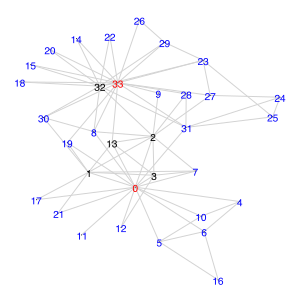

In [32]:
cls = ['red','blue','black','cyan']
g.vs['label_color'] = [cls[i] for i in kmeans.labels_]
ig.plot(g, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, vertex_label_size=10)

In [33]:
n_labels = 1
gnn = skn.gnn.GNNClassifier(dims=[hidden_dim, hidden_dim, hidden_dim, n_labels],
                    layer_types='Conv',
                    activations='ReLu',
                    verbose=True)
emb1 = gnn.fit_transform(A, features, labels=labels, n_epochs=100, random_state=42, history=True)


In epoch   0, loss: 1.313, train accuracy: 0.000
In epoch  10, loss: 0.694, train accuracy: 1.000
In epoch  20, loss: 0.693, train accuracy: 1.000
In epoch  30, loss: 0.693, train accuracy: 1.000
In epoch  40, loss: 0.693, train accuracy: 1.000
In epoch  50, loss: 0.693, train accuracy: 1.000
In epoch  60, loss: 0.693, train accuracy: 1.000
In epoch  70, loss: 0.693, train accuracy: 1.000
In epoch  80, loss: 0.693, train accuracy: 1.000
In epoch  90, loss: 0.693, train accuracy: 1.000


In [34]:
roles = np.argsort(emb1.flatten())
for i in range(len(roles)):
    g.vs[roles[i]]['label'] = i+1

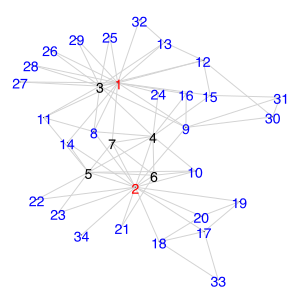

In [35]:
ig.plot(g, bbox=(300,300), edge_color='lightgrey', vertex_size=.1)

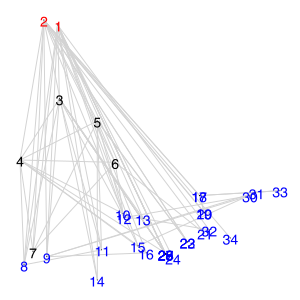

In [36]:
from sknetwork.embedding import SVD, PCA, Spring
svd = SVD(2)
emb = svd.fit_transform(features)
ig.plot(g, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, layout=emb)

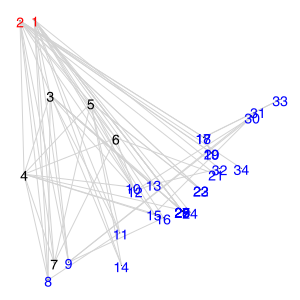

In [37]:
pca = PCA(2)
emb = pca.fit_transform(features)
ig.plot(g, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, layout=emb)

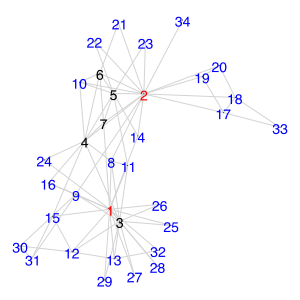

In [38]:
spr = Spring(2)
emb = spr.fit_transform(A)
ig.plot(g, bbox=(300,300), edge_color='lightgrey', vertex_size=.1, layout=emb)

In [44]:
(81+98+89+83+77)/5

85.6